In [1]:
'''
重做预处理，以邻域投票法为轮廓线上的点赋予标签
'''

import os
import numpy as np
from scipy.interpolate import splprep, splev
import networkx as nx
from sklearn.neighbors import KDTree

def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces

def load_mark_file(file_path):
    marks = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 3:
                    mark = [float(parts[0]), float(parts[1]), float(parts[2])]
                    marks.append(mark)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return marks

def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

def interpolate_marks(marks, num_points=100):
    marks = np.array(marks)
    marks = np.vstack([marks, marks[0]])  # 添加第一个点到最后，使曲线闭合
    tck, u = splprep(marks.T, s=0, per=True)
    u_fine = np.linspace(0, 1, num_points)
    interpolated_marks = splev(u_fine, tck)
    return np.array(interpolated_marks).T

def generate_graph(vertices, faces):
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i+1) % len(face)])
    return G

def is_on_curve(vertex, curve_points, tolerance):
    for point in curve_points:
        if np.linalg.norm(vertex - point) < tolerance:
            return True
    return False

def segment_point_cloud(vertices, faces, interpolated_marks):
    tolerance = 0.1
    max_tolerance = 1.0
    tolerance_increment = 0.02

    while tolerance <= max_tolerance:
        G = generate_graph(vertices, faces)
        curve_points = np.array(interpolated_marks)
        
        # 找到封闭曲线上的顶点
        curve_points_indices = set()
        for i, vertex in enumerate(vertices):
            if is_on_curve(np.array(vertex), curve_points, tolerance):
                curve_points_indices.add(i)
        
        # 从图中删除封闭曲线上的点
        G.remove_nodes_from(curve_points_indices)
        
        # 使用图的连通性找到两个区域
        components = list(nx.connected_components(G))
        part1 = set()
        part2 = set()
        
        if len(components) > 1:
            part1 = components[0]
            part2 = components[1]
            return part1, part2, curve_points_indices
        else:
            tolerance += tolerance_increment
    
    print("分割失败：无法找到两个独立的组件。")
    return set(), set(), set()

def perform_voting(vertices, part1, part2):
    # 创建 KDTree 以高效地查找邻域
    vertices_array = np.array(vertices)
    tree = KDTree(vertices_array)
    
    # 创建标签数组
    labels = np.zeros(len(vertices), dtype=int)
    labels[list(part1)] = 1
    labels[list(part2)] = 2
    
    # 创建一个临时标签数组用于存储投票结果
    temp_labels = np.zeros(len(vertices), dtype=int)
    
    # 设置邻域半径的初始值和最大值
    r_min = 0.2
    r_max = 1
    r_increment = 0.2
    
    # 对每个点进行投票
    for i, vertex in enumerate(vertices):
        if i in part1 or i in part2:
            continue  # 跳过已经标记的点
        
        # 初始化邻域半径
        r = r_min
        found_valid_neighbor = False
        
        while r <= r_max:
            # 查找邻居
            neighbors = tree.query_radius([vertex], r=r)[0]
            if len(neighbors) > 2:
                found_valid_neighbor = True
                break
            r += r_increment
        
        if not found_valid_neighbor:
            # 如果没有找到有效邻居，跳过该点
            continue
        
        # 如果找到有效邻居，进行标签投票
        neighbor_labels = labels[neighbors]
        
        # 计算每个类别的邻居数量
        num_part1_neighbors = np.sum(neighbor_labels == 1)
        num_part2_neighbors = np.sum(neighbor_labels == 2)
        
        # 投票决策
        if num_part1_neighbors > num_part2_neighbors:
            temp_labels[i] = 1
        elif num_part2_neighbors > num_part1_neighbors:
            temp_labels[i] = 2
        else:
            # 如果邻居类别数量相等，选择距离最近的邻居的类别
            distances = np.linalg.norm(vertices_array[neighbors] - vertex, axis=1)
            closest_neighbor_index = np.argmin(distances)
            temp_labels[i] = labels[neighbors][closest_neighbor_index]
    
    # 更新最终标签
    labels[temp_labels > 0] = temp_labels[temp_labels > 0]
    
    return labels

def save_labeled_point_cloud(vertices, labels, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        for i, vertex in enumerate(vertices):
            if labels[i] > 0:  # 仅保存已标记的点
                file.write(f"{vertex[0]} {vertex[1]} {vertex[2]} {labels[i]}\n")

def process_and_save_point_cloud(obj_file_path, mark_file_path, output_file_path):
    vertices, faces = load_obj_file(obj_file_path)
    marks = load_mark_file(mark_file_path)

    # print(f"加载的点数: {len(vertices)}")
    
    # 中心化顶点
    centered_vertices = center_vertices(vertices)

    # 获取插值标记点
    interpolated_marks = interpolate_marks(marks)

    # 分割点云
    part1, part2, inside_points = segment_point_cloud(centered_vertices, faces, interpolated_marks)

    # print(f"part1 点数: {len(part1)}")
    # print(f"part2 点数: {len(part2)}")
    # print(f"轮廓线上的点数: {len(inside_points)}")

    # 执行投票并保存标记的点云
    labels = perform_voting(centered_vertices, part1, part2)
    save_labeled_point_cloud(centered_vertices, labels, output_file_path)

    # 打印输出到 txt 文件的点数
    output_count = sum(1 for line in open(output_file_path))
    
    # 返回统计信息
    return len(vertices), len(inside_points), output_count

def process_directory(input_dir, output_dir):
    count = 1
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith(".obj"):
                obj_file_path = os.path.join(root, file)
                mark_file_path = obj_file_path + ".mark"
                output_file_name = os.path.splitext(file)[0] + "_labeled.txt"
                output_file_path = os.path.join(output_dir, output_file_name)

                if os.path.exists(mark_file_path):
                    # 处理并保存点云，获取统计信息
                    vertices_count, inside_points_count, output_count = process_and_save_point_cloud(obj_file_path, mark_file_path, output_file_path)
                    
                    # 打印统计信息
                    print(f"处理文件计数: {count}")
                    # print(f"加载的点云点数: {vertices_count}")
                    # print(f"轮廓线上的点数: {inside_points_count}")
                    # print(f"输出到 TXT 文件的点数: {output_count}")
                    
                    if vertices_count != output_count:
                        print(f"输入输出点云数量差: {vertices_count - output_count}")
                    
                    count += 1
                else:
                    print(f"未找到对应的标记文件: {obj_file_path}")

# 测试/运行
input_dir = r'D:/李娅宁/肩台外侧点-0715/肩台外侧点-0715'
output_dir = r'D:/李娅宁/肩台外侧点-0715/重新处理后的数据'

os.makedirs(output_dir, exist_ok=True)

process_directory(input_dir, output_dir)


处理文件计数: 1
输入输出点云数量差: 34
处理文件计数: 2
输入输出点云数量差: 31
处理文件计数: 3
输入输出点云数量差: 39
处理文件计数: 4
输入输出点云数量差: 18
处理文件计数: 5
输入输出点云数量差: 32
处理文件计数: 6
输入输出点云数量差: 27
未找到对应的标记文件: D:/李娅宁/肩台外侧点-0715/肩台外侧点-0715\1\1_6.obj
处理文件计数: 7
输入输出点云数量差: 32
处理文件计数: 8
输入输出点云数量差: 33
处理文件计数: 9
输入输出点云数量差: 47
处理文件计数: 10
输入输出点云数量差: 23
处理文件计数: 11
输入输出点云数量差: 37
处理文件计数: 12
输入输出点云数量差: 26
处理文件计数: 13
输入输出点云数量差: 31
处理文件计数: 14
输入输出点云数量差: 26
处理文件计数: 15
输入输出点云数量差: 42
处理文件计数: 16
输入输出点云数量差: 41
处理文件计数: 17
输入输出点云数量差: 30
处理文件计数: 18
输入输出点云数量差: 26
处理文件计数: 19
输入输出点云数量差: 30
处理文件计数: 20
输入输出点云数量差: 17
处理文件计数: 21
输入输出点云数量差: 53
处理文件计数: 22
输入输出点云数量差: 23
处理文件计数: 23
输入输出点云数量差: 2
处理文件计数: 24
输入输出点云数量差: 24
处理文件计数: 25
输入输出点云数量差: 14
处理文件计数: 26
输入输出点云数量差: 34
处理文件计数: 27
输入输出点云数量差: 22
处理文件计数: 28
输入输出点云数量差: 9
处理文件计数: 29
输入输出点云数量差: 39
处理文件计数: 30
处理文件计数: 31
输入输出点云数量差: 4
处理文件计数: 32
输入输出点云数量差: 15
处理文件计数: 33
输入输出点云数量差: 20
处理文件计数: 34
输入输出点云数量差: 27
处理文件计数: 35
输入输出点云数量差: 6
处理文件计数: 36
输入输出点云数量差: 15
处理文件计数: 37
输入输出点云数量差: 44
处理文件计数: 38
输入输出点云数量差: 11
处理文件计数: 39
输入输出点云数量差: 33
处

处理文件计数: 322
输入输出点云数量差: 14
处理文件计数: 323
输入输出点云数量差: 12
处理文件计数: 324
输入输出点云数量差: 15
处理文件计数: 325
输入输出点云数量差: 1
处理文件计数: 326
输入输出点云数量差: 16
处理文件计数: 327
输入输出点云数量差: 2
处理文件计数: 328
处理文件计数: 329
输入输出点云数量差: 8
处理文件计数: 330
输入输出点云数量差: 1
处理文件计数: 331
输入输出点云数量差: 21
处理文件计数: 332
输入输出点云数量差: 10
处理文件计数: 333
输入输出点云数量差: 3
处理文件计数: 334
输入输出点云数量差: 15
处理文件计数: 335
输入输出点云数量差: 12
处理文件计数: 336
输入输出点云数量差: 29
处理文件计数: 337
输入输出点云数量差: 15
处理文件计数: 338
输入输出点云数量差: 14
处理文件计数: 339
输入输出点云数量差: 40
处理文件计数: 340
输入输出点云数量差: 22
处理文件计数: 341
输入输出点云数量差: 10
处理文件计数: 342
输入输出点云数量差: 10
处理文件计数: 343
输入输出点云数量差: 18
处理文件计数: 344
输入输出点云数量差: 7
处理文件计数: 345
输入输出点云数量差: 8
处理文件计数: 346
输入输出点云数量差: 24
处理文件计数: 347
输入输出点云数量差: 24
处理文件计数: 348
输入输出点云数量差: 10
处理文件计数: 349
输入输出点云数量差: 15
处理文件计数: 350
输入输出点云数量差: 18
处理文件计数: 351
输入输出点云数量差: 18
处理文件计数: 352
输入输出点云数量差: 19
处理文件计数: 353
输入输出点云数量差: 14
处理文件计数: 354
输入输出点云数量差: 36
处理文件计数: 355
输入输出点云数量差: 2
处理文件计数: 356
输入输出点云数量差: 35
处理文件计数: 357
输入输出点云数量差: 17
处理文件计数: 358
输入输出点云数量差: 14
处理文件计数: 359
输入输出点云数量差: 11
处理文件计数: 360
输入输出点云数量差: 12
处理文件计数: 

处理文件计数: 638
输入输出点云数量差: 21
处理文件计数: 639
输入输出点云数量差: 35
处理文件计数: 640
输入输出点云数量差: 38
处理文件计数: 641
输入输出点云数量差: 19
处理文件计数: 642
输入输出点云数量差: 42
处理文件计数: 643
输入输出点云数量差: 18
处理文件计数: 644
输入输出点云数量差: 42
处理文件计数: 645
输入输出点云数量差: 42
处理文件计数: 646
输入输出点云数量差: 44
处理文件计数: 647
输入输出点云数量差: 36
处理文件计数: 648
输入输出点云数量差: 29
处理文件计数: 649
输入输出点云数量差: 26
处理文件计数: 650
输入输出点云数量差: 43
处理文件计数: 651
输入输出点云数量差: 36
处理文件计数: 652
输入输出点云数量差: 35
处理文件计数: 653
输入输出点云数量差: 51
处理文件计数: 654
输入输出点云数量差: 36
处理文件计数: 655
输入输出点云数量差: 41
处理文件计数: 656
输入输出点云数量差: 47
处理文件计数: 657
输入输出点云数量差: 33
处理文件计数: 658
输入输出点云数量差: 32
处理文件计数: 659
输入输出点云数量差: 37
处理文件计数: 660
输入输出点云数量差: 44
处理文件计数: 661
输入输出点云数量差: 32
处理文件计数: 662
输入输出点云数量差: 14
处理文件计数: 663
输入输出点云数量差: 18
处理文件计数: 664
输入输出点云数量差: 41
处理文件计数: 665
输入输出点云数量差: 47
处理文件计数: 666
输入输出点云数量差: 43
处理文件计数: 667
输入输出点云数量差: 23
处理文件计数: 668
输入输出点云数量差: 49
处理文件计数: 669
输入输出点云数量差: 28
处理文件计数: 670
输入输出点云数量差: 48
处理文件计数: 671
输入输出点云数量差: 34
处理文件计数: 672
输入输出点云数量差: 47
处理文件计数: 673
输入输出点云数量差: 34
处理文件计数: 674
输入输出点云数量差: 38
处理文件计数: 675
输入输出点云数量差: 40
处理文件计数: 676


处理文件计数: 955
输入输出点云数量差: 37
处理文件计数: 956
输入输出点云数量差: 34
处理文件计数: 957
输入输出点云数量差: 36
处理文件计数: 958
输入输出点云数量差: 16
处理文件计数: 959
输入输出点云数量差: 22
处理文件计数: 960
输入输出点云数量差: 26
处理文件计数: 961
输入输出点云数量差: 35
处理文件计数: 962
输入输出点云数量差: 10
处理文件计数: 963
输入输出点云数量差: 16
处理文件计数: 964
输入输出点云数量差: 29
处理文件计数: 965
输入输出点云数量差: 31
处理文件计数: 966
输入输出点云数量差: 34
处理文件计数: 967
输入输出点云数量差: 29
处理文件计数: 968
输入输出点云数量差: 39
处理文件计数: 969
输入输出点云数量差: 37
处理文件计数: 970
输入输出点云数量差: 25
处理文件计数: 971
输入输出点云数量差: 48
处理文件计数: 972
输入输出点云数量差: 43
处理文件计数: 973
输入输出点云数量差: 27
处理文件计数: 974
处理文件计数: 975
输入输出点云数量差: 21
处理文件计数: 976
输入输出点云数量差: 12
处理文件计数: 977
输入输出点云数量差: 13
处理文件计数: 978
输入输出点云数量差: 20
处理文件计数: 979
输入输出点云数量差: 16
处理文件计数: 980
输入输出点云数量差: 33
处理文件计数: 981
输入输出点云数量差: 24
处理文件计数: 982
输入输出点云数量差: 19
处理文件计数: 983
输入输出点云数量差: 22
处理文件计数: 984
输入输出点云数量差: 27
处理文件计数: 985
输入输出点云数量差: 35
处理文件计数: 986
输入输出点云数量差: 31
处理文件计数: 987
输入输出点云数量差: 41
处理文件计数: 988
输入输出点云数量差: 31
处理文件计数: 989
输入输出点云数量差: 40
处理文件计数: 990
输入输出点云数量差: 22
处理文件计数: 991
输入输出点云数量差: 28
处理文件计数: 992
输入输出点云数量差: 21
处理文件计数: 993
输入输出点云数量差: 13


<IPython.core.display.Javascript object>


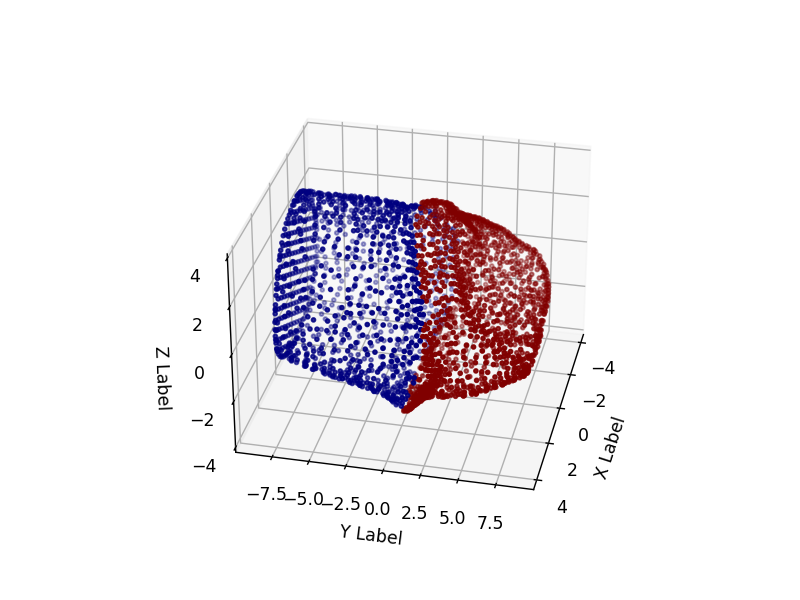

In [13]:
'''
辅助工具，用于查看输出txt文件的点云及其分类情况。
'''

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 开启交互旋转
%matplotlib notebook

def read_txt_file(file_path):
    # 读取包含四列的数据
    data = np.loadtxt(file_path, usecols=(0, 1, 2, 3))
    return data

def plot_scatter_3d(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    labels = data[:, 3]
    
    # 根据标签创建颜色映射
    unique_labels = np.unique(labels)
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
    label_to_color = {label: color for label, color in zip(unique_labels, colors)}
    
    # 为每个点分配颜色
    point_colors = np.array([label_to_color[label] for label in labels])
    
    ax.scatter(x, y, z, c=point_colors, marker='.')
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

# 文件路径
file_path = r'D:/李娅宁/肩台外侧点-0715/重新处理后的数据/130_labeled.txt'

# 读取数据
data = read_txt_file(file_path)

# 绘制散点图
plot_scatter_3d(data)
